## This is the script to generate Figure 3 and Figure S1b

In [4]:
library(dplyr)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2



In [2]:
out_dir <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/visualize4paper/Delta_fc_cpm_hk_genes"
setwd(out_dir)

In [ ]:
#iterate every group,
#to calculate delta_fold change for every filtered gene
#housekeeping gene indices
#non-housekeeping subsampling indices
#mean cpm (between exon and intron) 
#mean fold change (between exon and intron)
#then save the result to RData
for study in c("sra_tissues", "abnormal_conditions", "non-human_species", "gtex_tissue"){
    #load the differential analysis result by gene for introns and exons
    edger_file <- paste0("/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/dge_data_collection/stat_collected/DEG_tables.DESeq2.norm_intron_counts.",study,".all_reads.table.sig")
    intron_res_edger <- read.csv(edger_file, header=F, sep="\t")

    edger_file <- paste0("/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/dge_data_collection/stat_collected/DEG_tables.DESeq2.exon_counts_subsampled.",study,".all_reads.table.sig")
    exon_res_edger <- read.csv(edger_file, header=F, sep="\t")

    #read the list of house-keeping genes
    hk_gene_file <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/fc_cpm/House_keeping_genes_EnsemblIDs.txt"
    hk_gene_file_all_species <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/fc_cpm/House_keeping_genes_EnsemblIDs.all_species.txt"
    hk_genes <- read.csv(hk_gene_file, header=F)
    hk_genes <- unique(rbind(hk_genes, read.csv(hk_gene_file_all_species, header=F) ))


    #preprocess the differential expression result data frame, log-transform, change rownames
    preprocess_df <- function(df){
        colnames(df) <- c("study", "gene", "logFC", "logCPM", "PValue", "FDR")
        df$logCPM <- log2(df$logCPM+1)
        rownames(df) <- paste(df$study, df$gene, sep=".")
        df
    }

    intron_res <- preprocess_df(intron_res_edger)
    exon_res <- preprocess_df(exon_res_edger)

    #get genes have records in exon and intron results, and meet the CPM threshold
    get_shared_nonNA_DEG_table <- function(intron_res, exon_res, logCPM_thres){
        intron_edger_out <- intron_res
        exon_edger_out <- exon_res
        intron_edger_out <- intron_edger_out[intron_edger_out$logCPM>logCPM_thres, ]
        exon_edger_out <- exon_edger_out[exon_edger_out$logCPM>logCPM_thres, ]

        shared_genes <- intersect(rownames(intron_edger_out), rownames(exon_edger_out))
        non_NA_genes <- !is.na(intron_edger_out[shared_genes, "FDR"]) & !is.na(exon_edger_out[shared_genes, "FDR"])
        shared_genes <- shared_genes[non_NA_genes]
        intron_edger_shared <- intron_edger_out[shared_genes, ]
        exon_edger_shared <- exon_edger_out[shared_genes, ]
        list(intron_nonNA_shared=intron_edger_shared,
             exon_nonNA_shared=exon_edger_shared
            )
    }

    logCPM_thres <- 5
    shared_nonNA_DEG_tables <- get_shared_nonNA_DEG_table(intron_res, exon_res, logCPM_thres)
    intron_edger_shared <- shared_nonNA_DEG_tables$intron_nonNA_shared
    exon_edger_shared <- shared_nonNA_DEG_tables$exon_nonNA_shared

    #filter genes based on logCPM, logFC and P-value
    dge_gene_indices <- exon_edger_shared$logCPM > 5 & intron_edger_shared$logCPM > 5 & 
    ((abs(exon_edger_shared$logFC) >0.5 & exon_edger_shared$PValue < 0.05) |  (abs(intron_edger_shared$logFC) > 0.5 & 
       intron_edger_shared$PValue < 0.05 ) )

    #cbind the exon table and intron table
    colnames(exon_edger_shared) <- paste("exon.", colnames(exon_edger_shared), sep="")
    colnames(intron_edger_shared) <- paste("intron.", colnames(intron_edger_shared), sep="")
    exon_intron <- cbind(exon_edger_shared[dge_gene_indices,], intron_edger_shared[dge_gene_indices,])

    write.table(exon_intron, paste0(study, ".table_pasted_exon_intron.txt"), sep="\t", quote=F)

    rnames <- rownames(exon_intron)
    id_index <- grep("ENS", strsplit(rownames(exon_intron)[1],"\\.")[[1]])
    exon_intron$ensID <- sapply(strsplit(rnames, "\\."), `[`, id_index)

    #get house keeping gene indices
    hk_indices <- exon_intron$ensID %in% hk_genes[,1]

    sum(hk_indices)
    sum(!hk_indices)

    #calculate delta fold change, mean fold change, and mean CPM for every filtered gene
    delta_fc <- abs(exon_intron$exon.logFC) - abs(exon_intron$intron.logFC)
    mean_fc <- (abs(exon_intron$exon.logFC)+ abs(exon_intron$intron.logFC))/2
    mean_cpm <- (exon_intron$exon.logCPM + exon_intron$intron.logCPM)/2

    #calculate mean delta fold change, median delta fold change by study. Add a column of differentially expressed gene count
    deg_counts <- table(exon_intron$exon.study)
    mean_delta_fc_by_study <- aggregate(delta_fc, by=list(exon_intron$exon.study), FUN=mean)
    median_delta_fc_by_study <- aggregate(delta_fc, by=list(exon_intron$exon.study), FUN=median)
    indices <- match(names(deg_counts), mean_delta_fc_by_study$Group.1)
    mean_fc_by_study_deg_counts <- cbind(mean_delta_fc_by_study[indices, ], deg_counts)


    #function to subsampled non-housekeeping genes
    #to make them have the same abundance and fold change distribution as non-housekeeping genes
    make_two_bb_has_same_distrib_as_aa <- function(aa1, bb1, aa2, bb2, output_bb_size_scale=1, bin.num1=30, bin.num2=30){
        #this function can sample the indices from bbs, to make bb1 has the same distribution as aa1,
        #and bb2 has the same distribution as aa2
        #aa1 and aa2, bb1 and bb2 has to have the same length!

        if(length(bb1)!=length(bb2) | length(aa1)!=length(aa2)){
            print("aa1 and aa2, bb1 and bb2 has to have the same length!")
        }
        aa1.len <- length(aa1)
        aa2.len <- length(aa2)
        bb.len <- length(bb1)
        small_num1 <- min(abs(aa1), abs(bb1))/10
        small_num2 <- min(abs(aa2), abs(bb2))/10

        breaks1 <- seq(from = min(aa1, bb1)-small_num1, to=max(aa1,bb1)+small_num1, length.out=bin.num1)
        breaks2 <- seq(from = min(aa2, bb2)-small_num2, to=max(aa2,bb2)+small_num2, length.out=bin.num2)
        aa1.cut <- cut(aa1, breaks1)
        aa1.cut.table <- table(aa1.cut)
        bb1.cut <- cut(bb1, breaks1)

        aa2.cut <- cut(aa2, breaks2) 
        aa2.cut.table <- table(cut(aa2, breaks2))
        bb2.cut <- cut(bb2, breaks2)

        set.seed(88)

        sampled_indices <- c()

        for(i in 1:length(aa1.cut.table)){
        for(j in 1:length(aa2.cut.table)){

            interval_name1 <- names(aa1.cut.table)[i]
            interval_name2 <- names(aa2.cut.table)[j]

            aa_counts <- sum(aa1.cut==interval_name1 & aa2.cut==interval_name2)
            bb_index_in_the_interval <- (1:bb.len)[bb1.cut==interval_name1 & bb2.cut==interval_name2]

            this_sample <- bb_index_in_the_interval
            if(aa_counts*output_bb_size_scale < length(bb_index_in_the_interval)){
                this_sample <- sample(bb_index_in_the_interval, size=aa_counts*output_bb_size_scale)
            }

            sampled_indices <- c(sampled_indices, this_sample)
        }
        }
        sampled_indices
    }

    sel_indices <- make_two_bb_has_same_distrib_as_aa(
        aa1=mean_cpm[hk_indices],
        bb1=mean_cpm[!hk_indices],
        aa2=mean_fc[hk_indices],
        bb2=mean_fc[!hk_indices],
        bin.num1=50, 
        bin.num2=50
        )

    wilcox.test(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], alternative="less")

    save(delta_fc, hk_indices, sel_indices, mean_cpm, mean_fc, file = paste0(study, ".delta_fc_cpm_hk_genes.RData"))
}

In [360]:
study <- "gtex_tissue"
load(paste0(study, ".delta_fc_cpm_hk_genes.RData"))

In [3]:
vis_dir <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/visualize4paper/Figures/"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


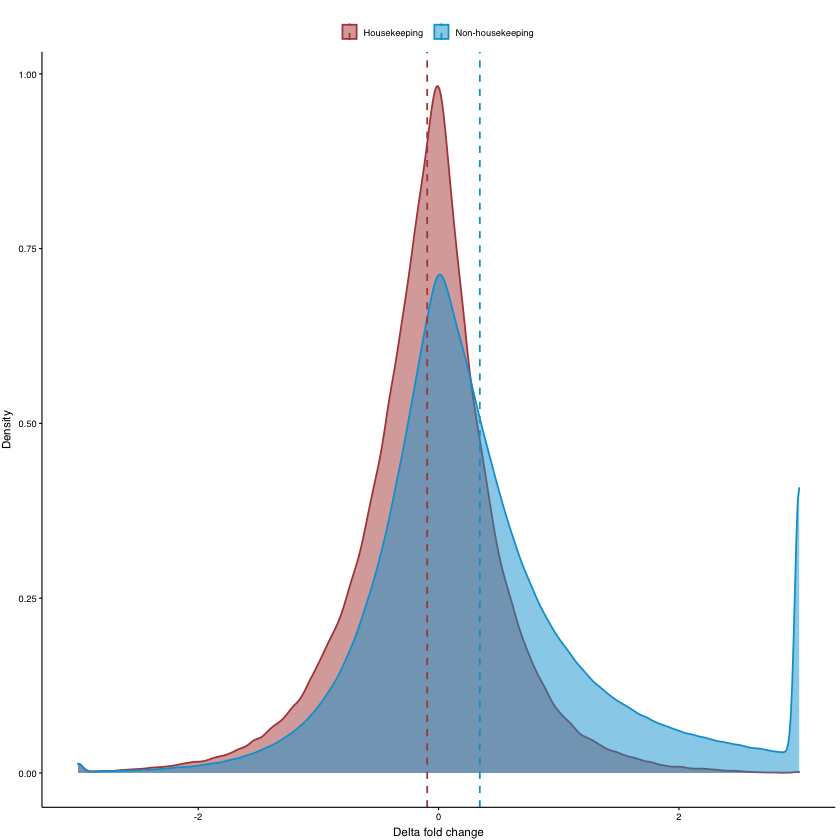


	Wilcoxon rank sum test with continuity correction

data:  delta_fc[hk_indices] and delta_fc[!hk_indices][sel_indices]
W = 2.1725e+10, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0


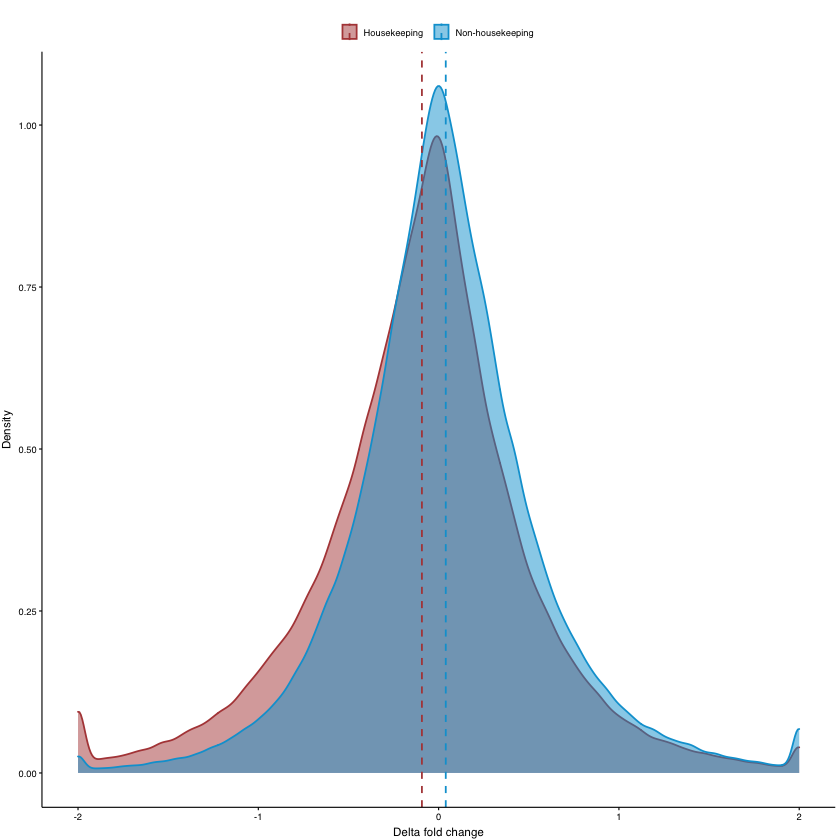

In [362]:
source("/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/visualize4paper/shared/shared.R")
plot_density_plot_for_hk_dfc <- function(delta_fc_hk, delta_fc_nhk, title, xlim=2){
    dat <- data.frame(delta_fc=delta_fc_hk, group="Housekeeping")
    dat <- rbind(dat, data.frame(delta_fc=delta_fc_nhk, group="Non-housekeeping"))
    dat$delta_fc[dat$delta_fc>xlim] <- xlim
    dat$delta_fc[dat$delta_fc < -1*xlim] <- -1*xlim
    ggdensity(dat, x="delta_fc", 
            add = "mean", rug = FALSE,
            color = "group", fill = "group",
            palette = c(col_sz[c(4,1)]),
            title="",
            xlab="Delta fold change",
            ylab="Density"
    ) +
    theme_Publication() +
    theme(legend.title = element_blank(),
         panel.grid.major = element_blank())
}

#plot the density plot for dfc in housekeeping gene and non-house keeping genes
plot_density_plot_for_hk_dfc(delta_fc[hk_indices], delta_fc[!hk_indices], "Original", xlim=3)
ggsave(paste0(vis_dir, "/Figure3a.pdf"), width = 2.1, height = 2.1, units = "in")
#plot the density plot for dfc in housekeeping gene and subsampled non-house keeping genes
plot_density_plot_for_hk_dfc(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], "non-housekeeping genes sub-sampled")
ggsave(paste0(vis_dir, "/Figure3d.pdf"), width = 2.1, height = 2.1, units = "in")
#test the difference of delta fold change between housekeeping genes and subsampled non-housekeeping genes 
wilcox.test(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], alternative="less")


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


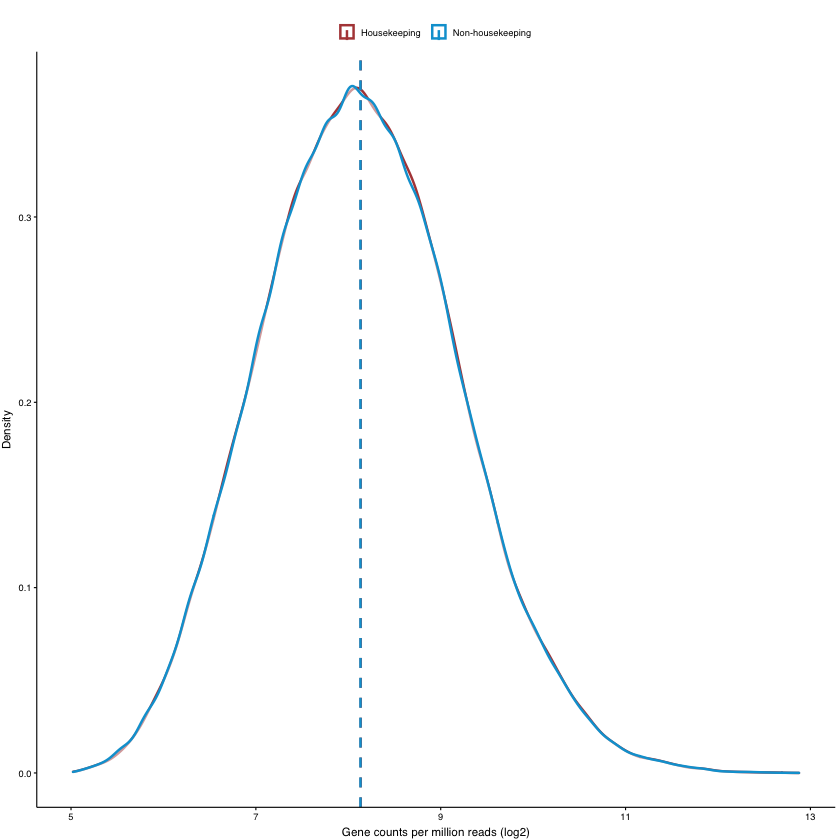

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“Removed 9522 rows containing non-finite values (stat_density).”


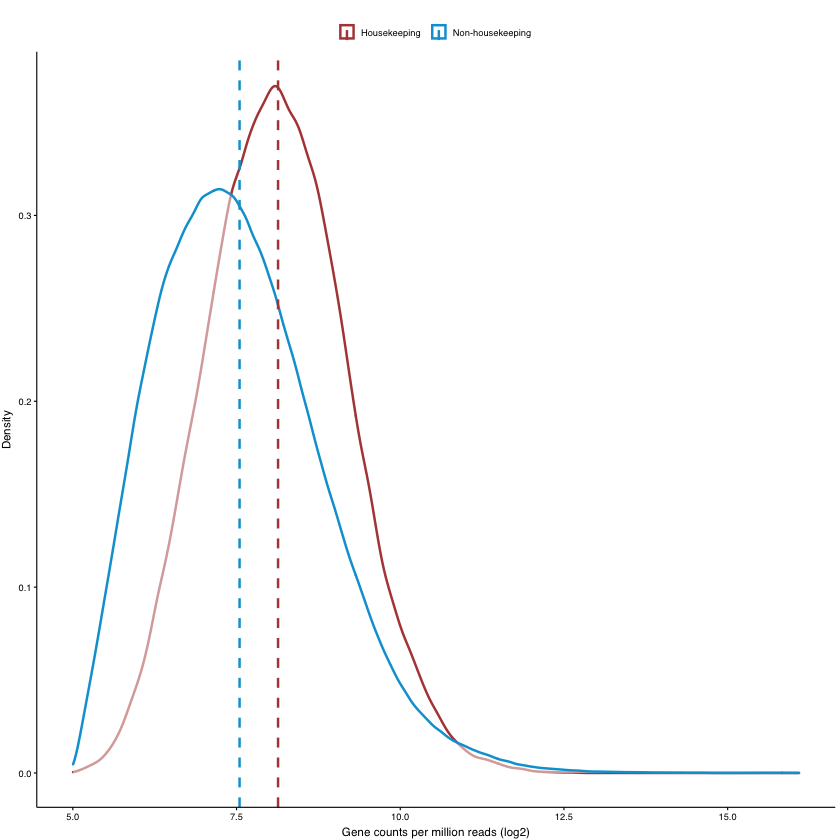

Warning message:
“Removed 9522 rows containing non-finite values (stat_density).”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


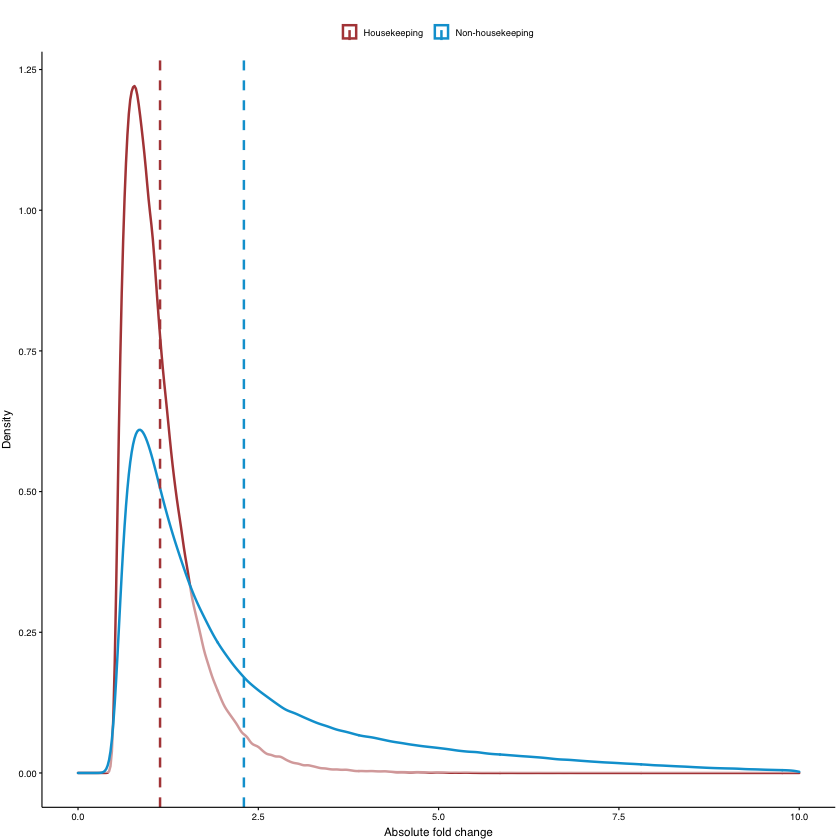

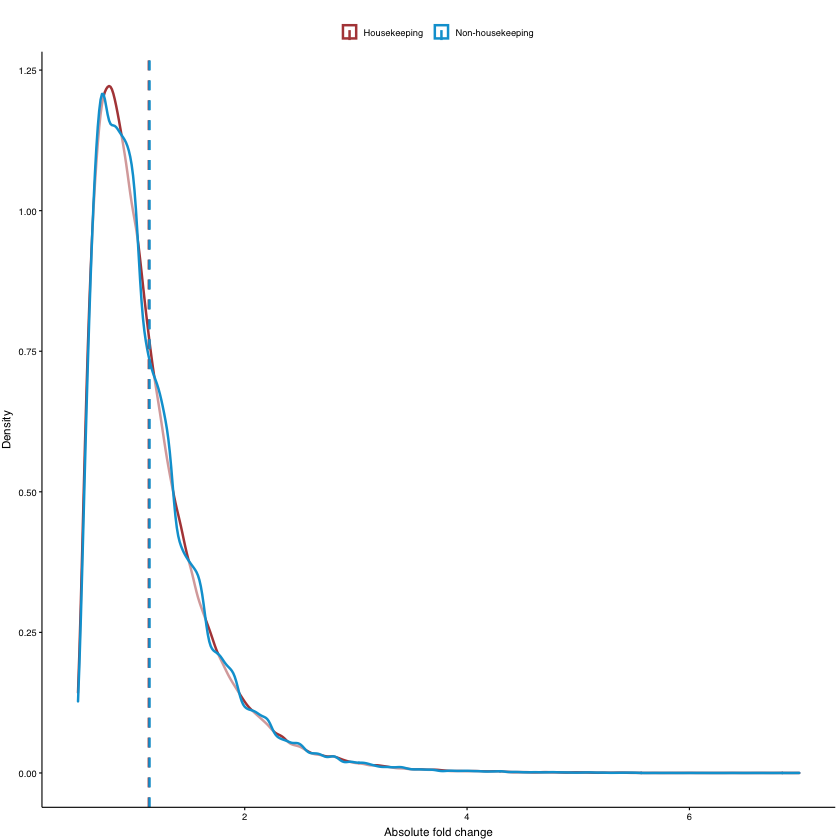

In [363]:
plot_density_plot_for_hk_cpm_fc <- function(cpm_fc_hk, cpm_fc_nhk, title, xlab=""){
    dat <- data.frame(cpm_fc=cpm_fc_hk, group="Housekeeping")
    dat <- rbind(dat, data.frame(cpm_fc=cpm_fc_nhk, group="Non-housekeeping"))

    ggdensity(dat, x="cpm_fc", 
            add = "mean", rug = FALSE,
            color = "group",
            palette = c(col_sz[c(4,1)]),
            title=title,
            xlab=xlab,
            ylab="Density",
             size=0.7 
            
    )+theme_Publication() +
    theme(legend.title = element_blank(),
         panel.grid.major = element_blank())
}
#plot the density of Gene counts per million reads (log2) in housekeeping genes and subsampled non-house keeping genes
plot_density_plot_for_hk_cpm_fc(mean_cpm[hk_indices], mean_cpm[!hk_indices][sel_indices], "", xlab="Gene counts per million reads (log2)")
ggsave(paste0(vis_dir, "/Figure3e.pdf"), width = 2, height = 2.1, units = "in")
#plot the density of Gene counts per million reads (log2) in housekeeping genes and non-house keeping genes
plot_density_plot_for_hk_cpm_fc(mean_cpm[hk_indices], mean_cpm[!hk_indices], "", xlab="Gene counts per million reads (log2)")
ggsave(paste0(vis_dir, "/Figure3b.pdf"), width = 2, height = 2.1, units = "in")

#plot the density of Absolute fold change in housekeeping genes and non-house keeping genes
plot_density_plot_for_hk_cpm_fc(mean_fc[hk_indices], mean_fc[!hk_indices], "", xlab="Absolute fold change") +xlim(0, 10)
ggsave(paste0(vis_dir, "/Figure3c.pdf"), width = 2, height = 2.1, units = "in")
#plot the density of Absolute fold change in housekeeping genes and subsampled non-house keeping genes
plot_density_plot_for_hk_cpm_fc(mean_fc[hk_indices], mean_fc[!hk_indices][sel_indices], "", xlab="Absolute fold change")
ggsave(paste0(vis_dir, "/Figure3f.pdf"), width = 2.1, height = 2.1, units = "in")

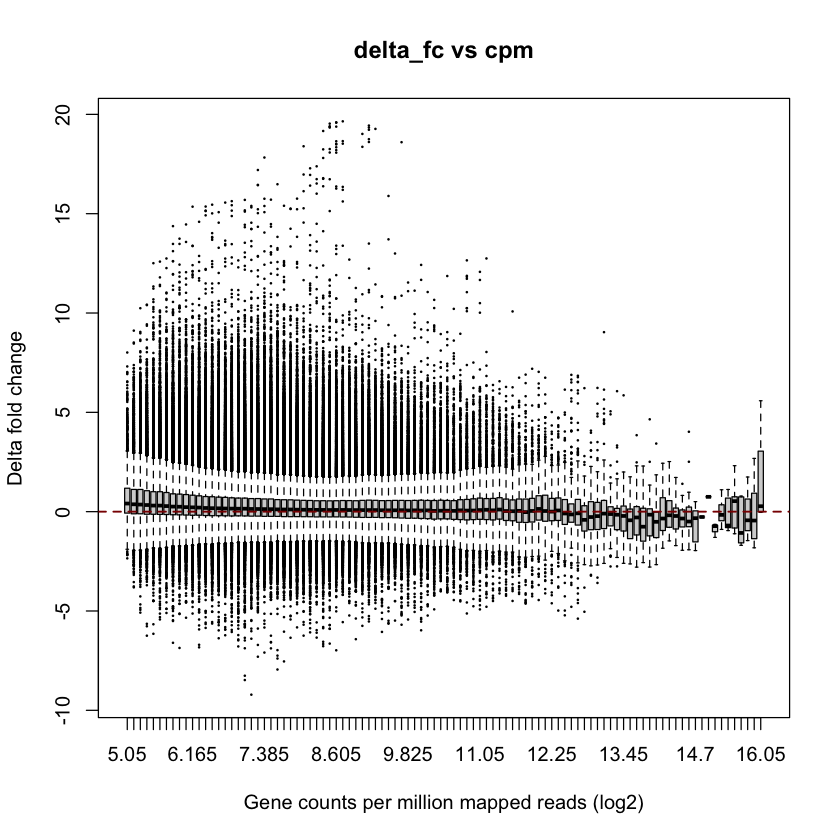

In [5]:
study <- "gtex_tissue"
#Plot the boxplot for delta fold change vs logCPM
load(paste0(study, ".delta_fc_cpm_hk_genes.RData"))

plot_delta_fc_vs_cpm_fc <- function(val, delta_fc, xlab, main){
    cut_val <- cut(val,100)
    cut_borders <- function(x){
        pattern <- "(\\(|\\[)(-*[0-9]+\\.*[0-9]*),(-*[0-9]+\\.*[0-9]*)(\\)|\\])"

        start <- as.numeric(gsub(pattern,"\\2", x))
        end <- as.numeric(gsub(pattern,"\\3", x))
        mean <- (start+end)/2
        data.frame(start, end, mean)
    }
    #cut_borders(cut_val)
    dat <- cbind(data.frame(delta_fc), cut_borders(cut_val))
    boxplot(delta_fc~mean, 
            data=dat, 
            outcex=0.15,
            ylab="Delta fold change",
            xlab=xlab,
            main=main
           )
    abline(h=0, lty=2, lwd=1.5, col="darkred")
}

plot_delta_fc_vs_cpm_fc(mean_cpm, delta_fc, main="delta_fc vs cpm", xlab="Gene counts per million mapped reads (log2)")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”



	Wilcoxon rank sum test with continuity correction

data:  delta_fc[hk_indices] and delta_fc[!hk_indices][sel_indices]
W = 585267047, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


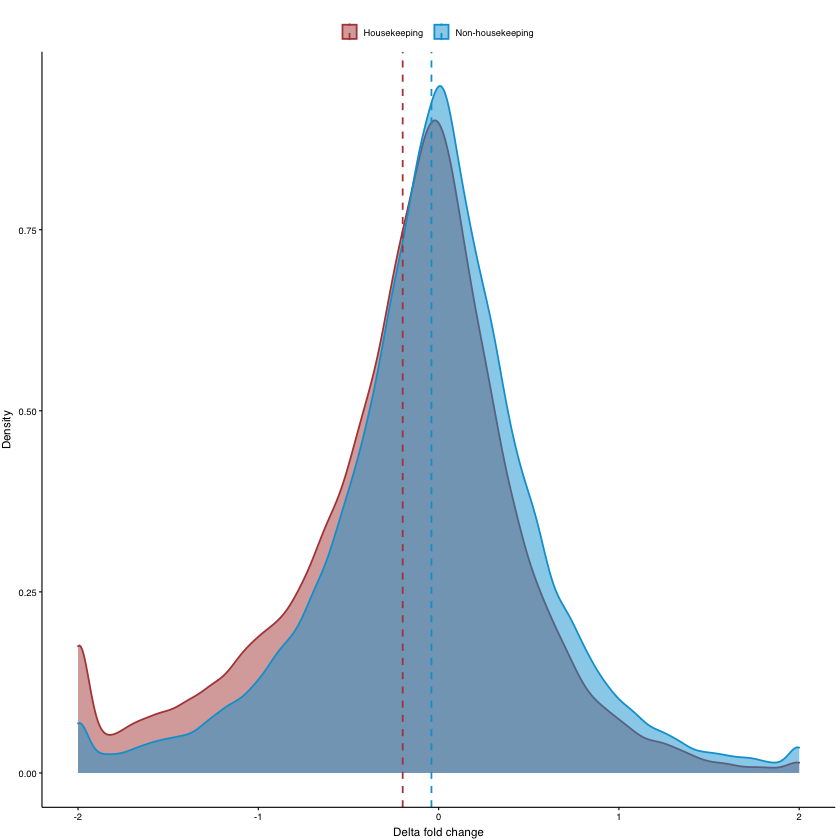


	Wilcoxon rank sum test with continuity correction

data:  delta_fc[hk_indices] and delta_fc[!hk_indices][sel_indices]
W = 12622459, p-value = 0.002918
alternative hypothesis: true location shift is less than 0


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


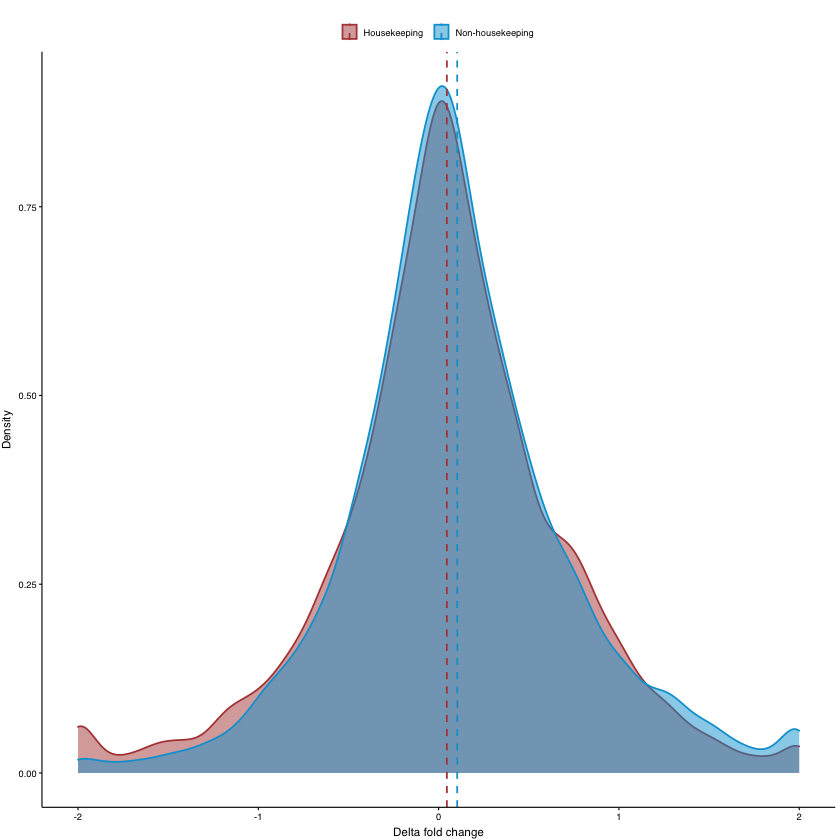


	Wilcoxon rank sum test with continuity correction

data:  delta_fc[hk_indices] and delta_fc[!hk_indices][sel_indices]
W = 80736, p-value = 0.04738
alternative hypothesis: true location shift is less than 0


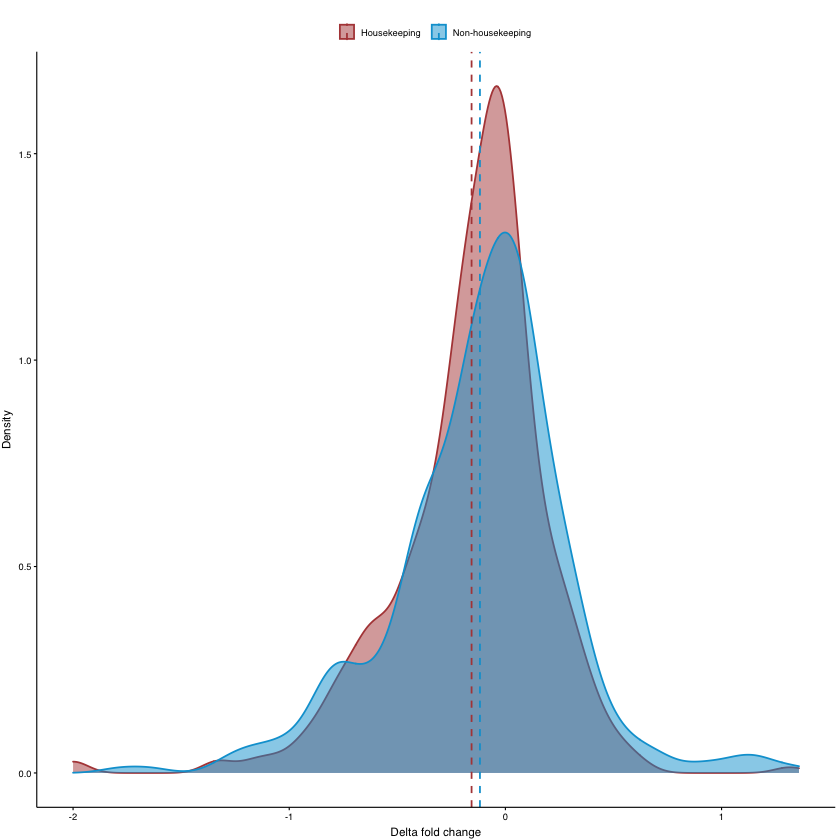

In [365]:
study <- "sra_tissues"
#plot the density plot for dfc in housekeeping gene and subsampled non-house keeping genes in SRA tissues
load(paste0(study, ".delta_fc_cpm_hk_genes.RData"))
plot_density_plot_for_hk_dfc(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], "non-housekeeping genes sub-sampled")
ggsave(paste0(vis_dir, "/Figure3g.pdf"), width = 2.1, height = 2.1, units = "in")
wilcox.test(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], alternative="less")

#plot the density plot for dfc in housekeeping gene and subsampled non-house keeping genes in Non-human species
study <- "non-human_species"
load(paste0(study, ".delta_fc_cpm_hk_genes.RData"))
plot_density_plot_for_hk_dfc(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], "non-housekeeping genes sub-sampled")
ggsave(paste0(vis_dir, "/Figure3h.pdf"), width = 2.1, height = 2.1, units = "in")

wilcox.test(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], alternative="less")
#plot the density plot for dfc in housekeeping gene and subsampled non-house keeping genes in diseases
study <- "abnormal_conditions"
load(paste0(study, ".delta_fc_cpm_hk_genes.RData"))
plot_density_plot_for_hk_dfc(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], "non-housekeeping genes sub-sampled")
ggsave(paste0(vis_dir, "/Figure3i.pdf"), width = 2.1, height = 2.1, units = "in")
wilcox.test(delta_fc[hk_indices], delta_fc[!hk_indices][sel_indices], alternative="less")
